## Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from scipy import stats
import matplotlib.dates as mdates
from plotly import tools
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

init_notebook_mode(connected=True)
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

## Loading Data

In [3]:
df = pd.read_csv('./all_stocks_5yr.csv')

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


### Data cleaning

In [5]:
# rename Name to ticks
rdf = df.rename(columns={'Name':'ticks'})

# drop the null as they a few values and time-series won't be affected by such values
rdf.dropna(inplace=True)

# change the dtype of date column
new_df = rdf.copy()
new_df.loc[:, 'date'] = pd.to_datetime(rdf.loc[:, 'date'])

# new dataframe info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619029 non-null  object 
 1   open    619029 non-null  float64
 2   high    619029 non-null  float64
 3   low     619029 non-null  float64
 4   close   619029 non-null  float64
 5   volume  619029 non-null  int64  
 6   ticks   619029 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 37.8+ MB


In [6]:
def subdataframe(df, tick):
    
    # top 10 ticks
    ticks = ['AAPL', 'FB', 'INTC', 'AMD']
    
    assert tick in ticks
    ndf = new_df[new_df['ticks'] == tick]
    return ndf

In [7]:
company_dict = {'AAPL':'Apple',
                'FB':'Facebook', 
                'AMD':'Adavanced Micro Devices',
                'INTC':'Intel Corp'
               }


aapl_df = subdataframe(new_df, 'AAPL')
fb_df = subdataframe(new_df, 'FB')
amd_df = subdataframe(new_df, 'AMD')
intc_df = subdataframe(new_df, 'INTC')

def dailyfunc(df):
    df['daily return'] = ((df['close'] - df['open'])/df['open'])*100
    df.style.format('{:.2f}%', subset='daily return')
    df['daily_mean'] = (df['open'] + df['close'] + df['high'] + df['low'])/4
    df['co_name'] = company_dict[df['ticks'].unique()[0]]
    return df


aapl_df = dailyfunc(aapl_df)
fb_df = dailyfunc(fb_df)
amd_df = dailyfunc(amd_df)
intc_df = dailyfunc(intc_df)


In [8]:
print('\t\tStart Date\t\t\t\t\tEnd Date')
print(f"AAPL\t\t{aapl_df['date'].min()}\t\t\t{aapl_df['date'].max()}")
print(f"FB\t\t{fb_df['date'].min()}\t\t\t{fb_df['date'].max()}")
print(f"AMD\t\t{amd_df['date'].min()}\t\t\t{amd_df['date'].max()}")
print(f"INTC\t\t{intc_df['date'].min()}\t\t\t{intc_df['date'].max()}")

		Start Date					End Date
AAPL		2013-02-08 00:00:00			2018-02-07 00:00:00
FB		2013-02-08 00:00:00			2018-02-07 00:00:00
AMD		2013-02-08 00:00:00			2018-02-07 00:00:00
INTC		2013-02-08 00:00:00			2018-02-07 00:00:00


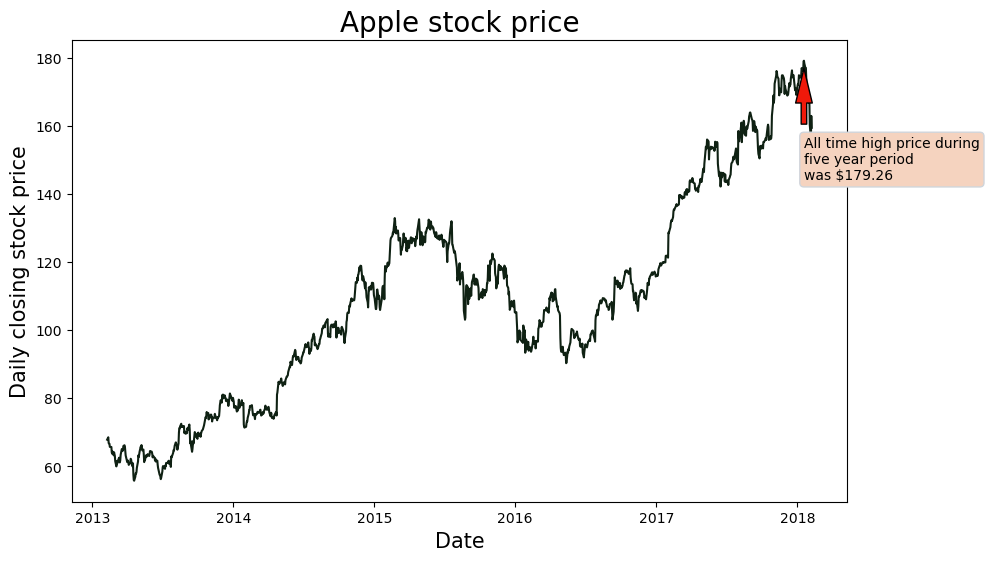

In [9]:
def closing_stock_price(df):
    
    # define highest stock over 5 period of time with date of the same
    high = df['close'].max()
    datetime = df[df['close'] == df['close'].max()]['date'].values
    
    if df['ticks'].unique()[0] == 'AAPL':
        fig, ax = plt.subplots(figsize=(10,6))
    elif df['ticks'].unique()[0] == 'FB':
        fig, ax = plt.subplots(figsize=(10,6))
    else:
        fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(df['date'], df['close'], color='#0f2113')
    ax.set_title(f"{df['co_name'].unique()[0]} stock price", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily closing stock price", fontsize=15)
    if df['ticks'].unique()[0] == 'AAPL':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-35),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'FB':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-50),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    else:
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-10),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))

    plt.show()
    
# plot of all the closing stocks
closing_stock_price(aapl_df)



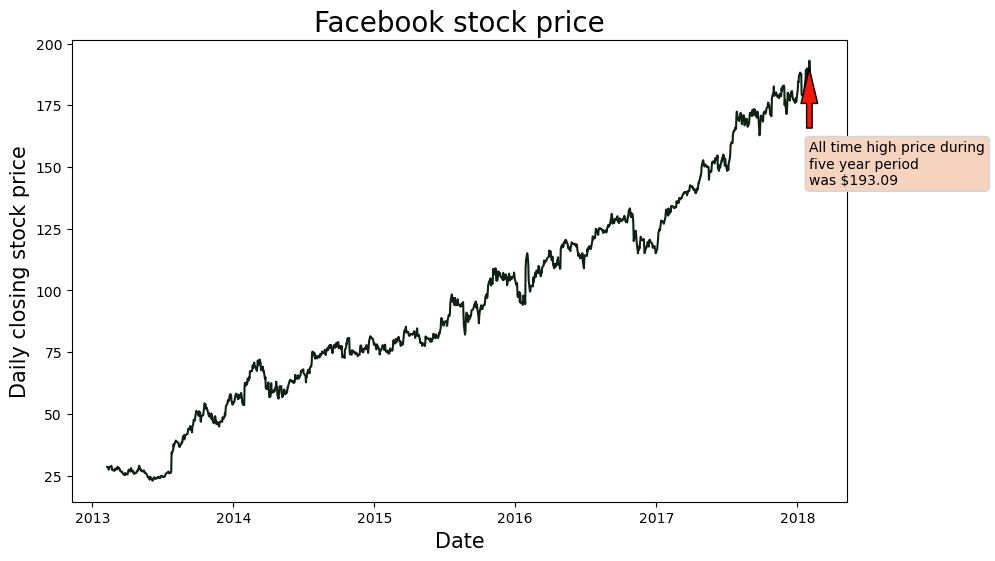

In [10]:
closing_stock_price(fb_df)

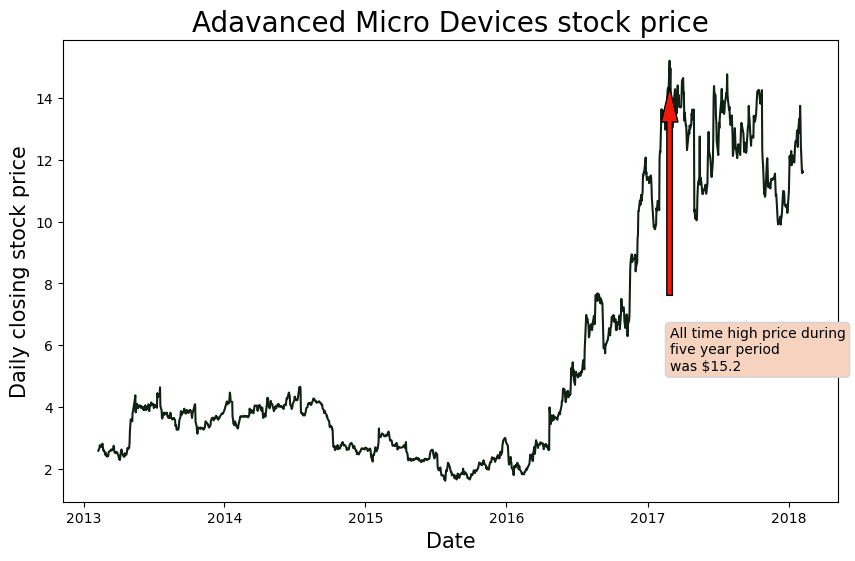

In [11]:
closing_stock_price(amd_df)

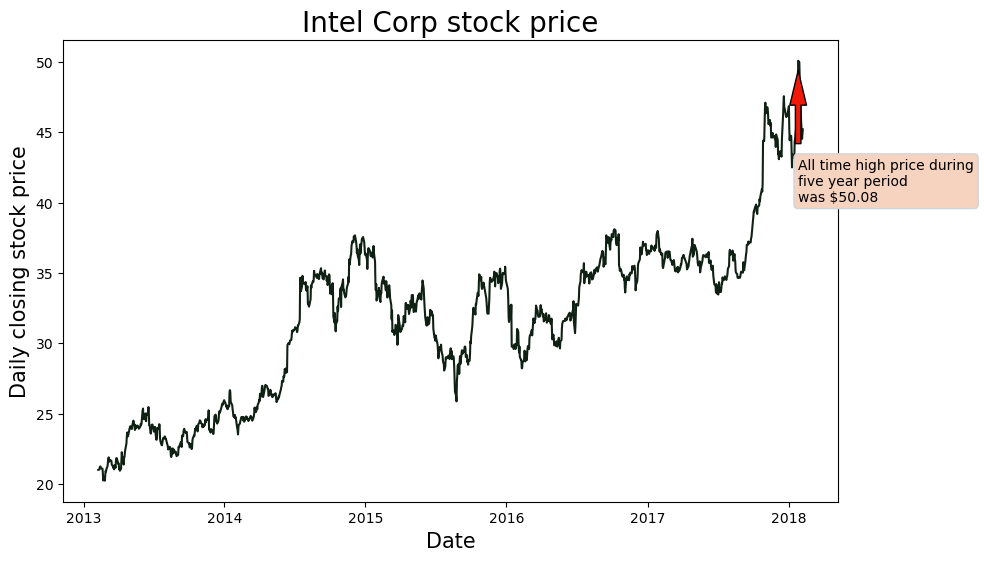

In [12]:
closing_stock_price(intc_df)

In [13]:
def mav_function(df):
    
    # calclulate moving averages of 10,50 and 200 days
    df['10_d_avg'] = df['close'].rolling(window=10).mean()
    df['50_d_avg'] = df['close'].rolling(window=50).mean()
    df['200_d_avg'] = df['close'].rolling(window=200).mean()
    
    return df

# let's analyse apple and facebook stocks using moving averages methods
aapl_df = mav_function(aapl_df)
fb_df = mav_function(fb_df)

In [14]:
aapl_dfn = aapl_df.copy()
fb_dfn = fb_df.copy()

def mav_chart(df):
    df = df.set_index('date')
    
    fig = tls.make_subplots(rows=2, cols=1, shared_xaxes=True)
    # set colors and cols names to be plotted
    colors = ['#ff4500', '#92a1cf', '#6E6E6E']
    avgs = ['10_d_avg','50_d_avg','200_d_avg']
    
    for col, c in zip(avgs, colors):
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': col, 'line': {'color': c}},1,1)
    for col in ['close']:
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': 'closing price', 'line': {'color': '#393f5e'}},2,1)
        
    fig['layout'].update(height=800,
                         title=f"Relationship between Moving averages <br> and Closing Price of {df['co_name'].unique()[0]}")
    fig.show()

### MA of FB

In [15]:
mav_chart(fb_dfn)

### MA of AAPL

In [16]:
mav_chart(aapl_dfn)

## Stock price forecasting

In [17]:
# create function to return dataframe for forecating
def df_formatting(df):
    df = df.loc[:, ['date','close']]
    df.rename(columns={'date':'ds', 'close':'y'}, inplace=True)
    
    return df

aplph_df = df_formatting(aapl_df)
fbph_df = df_formatting(fb_df)

In [18]:
# forecasting using prophet
def price_forecasting(df, period):
    
    prophet = Prophet(yearly_seasonality = 'auto')
    prophet.fit(df)
    future_price = prophet.make_future_dataframe(periods=period)
    forecasts = prophet.predict(future_price)
    forecast = forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    
    # plot the foreasts
    fig = prophet.plot(forecasts)
    a = add_changepoints_to_plot(fig.gca(), prophet, forecasts)
    
    # plot the components 
    fig2 = prophet.plot_components(forecasts)
    
    return forecasts

20:12:41 - cmdstanpy - INFO - Chain [1] start processing
20:12:42 - cmdstanpy - INFO - Chain [1] done processing


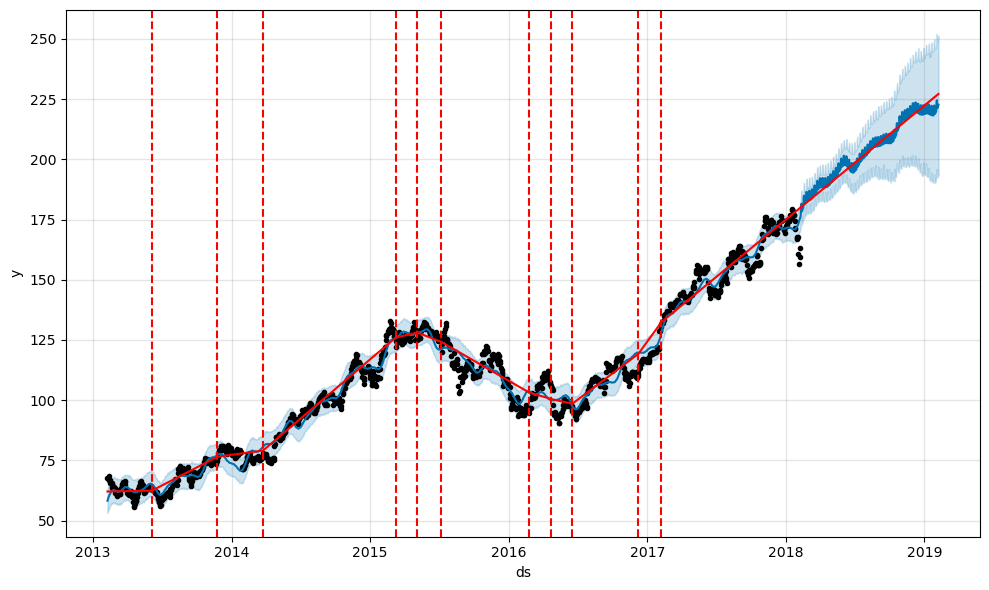

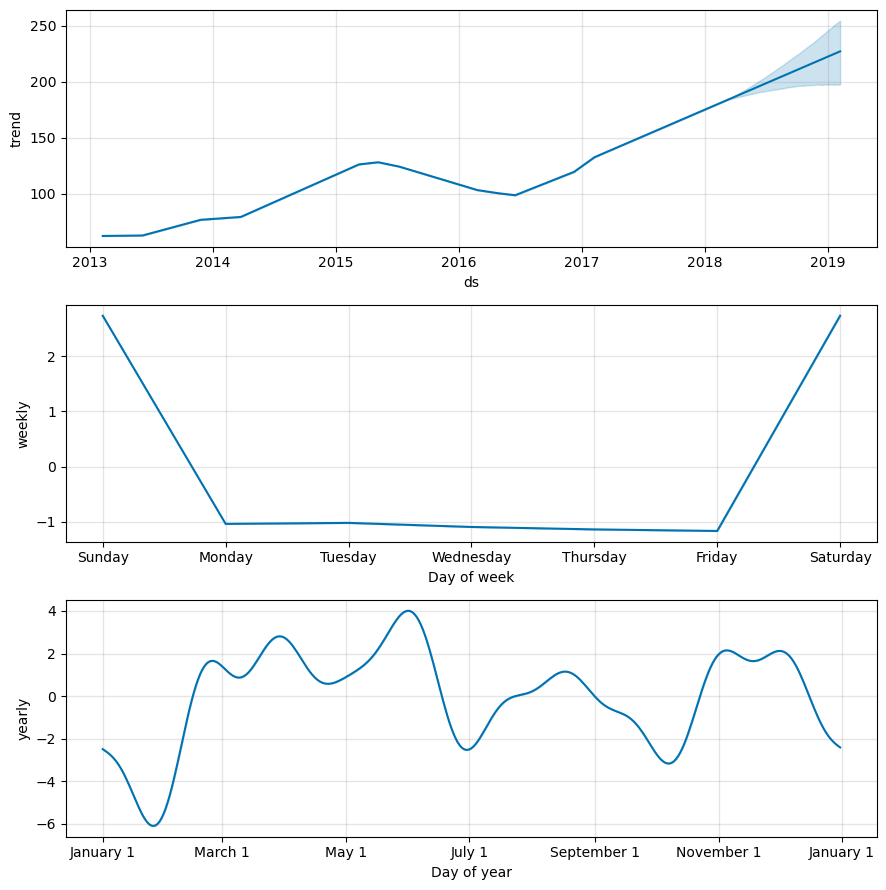

In [19]:
forecast_aapl = price_forecasting(aplph_df, 365)

20:12:43 - cmdstanpy - INFO - Chain [1] start processing
20:12:43 - cmdstanpy - INFO - Chain [1] done processing


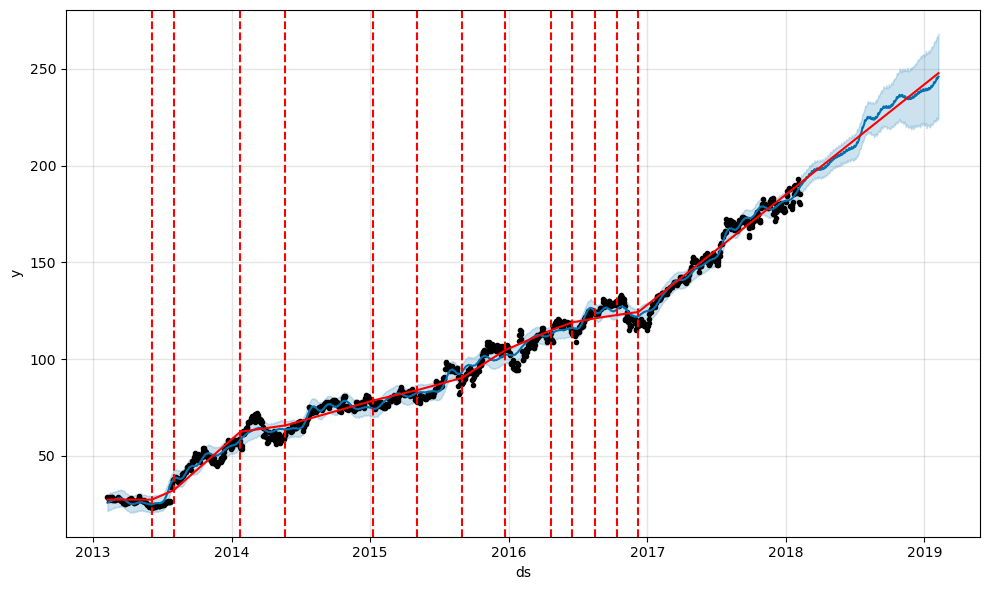

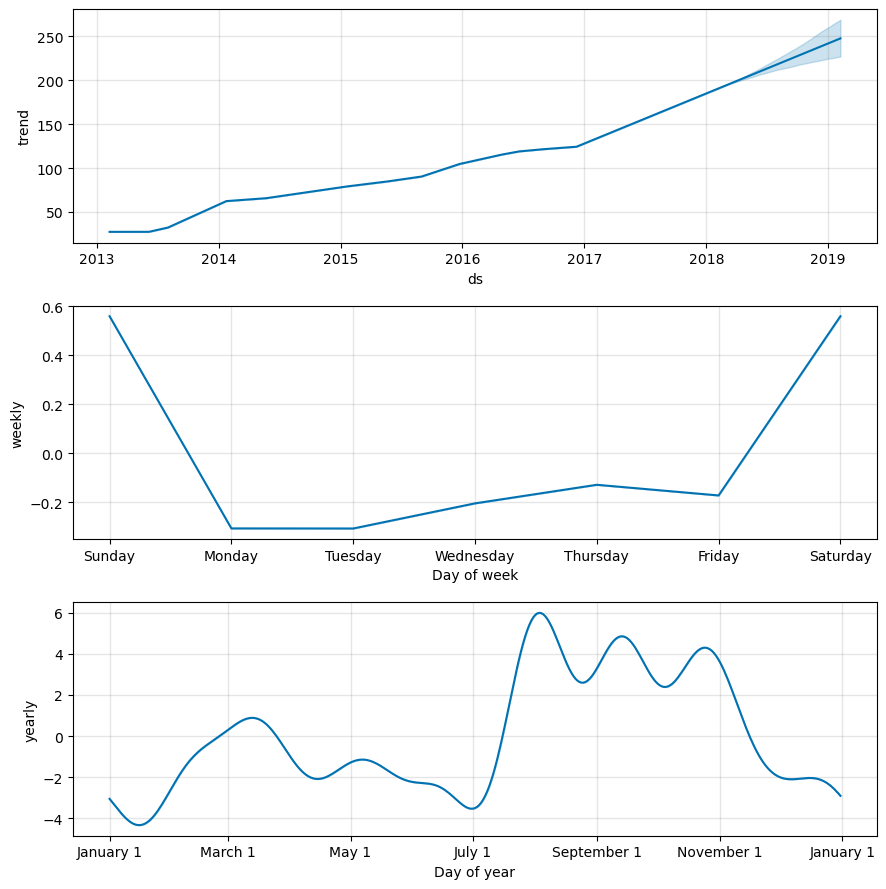

In [20]:
forecast_fb = price_forecasting(fbph_df, 365)

## Forecasting using Auto-ARIMA models

In [21]:
#find seasonla decomposition of time-series models
def decomposition(df, period):
    # decompistion instance
    result_decom = seasonal_decompose(df['y'], model="additive", 
                                      period=period, extrapolate_trend='freq')
    # plot the componenets 
    fig = result_decom.plot()
    fig.set_size_inches((10, 6))
    # Tight layout to realign things
    fig.tight_layout()
    plt.show()
    
    # capture the compoenets 
    trend = result_decom.trend
    season = result_decom.seasonal
    reside = result_decom.resid
    return trend, season, reside

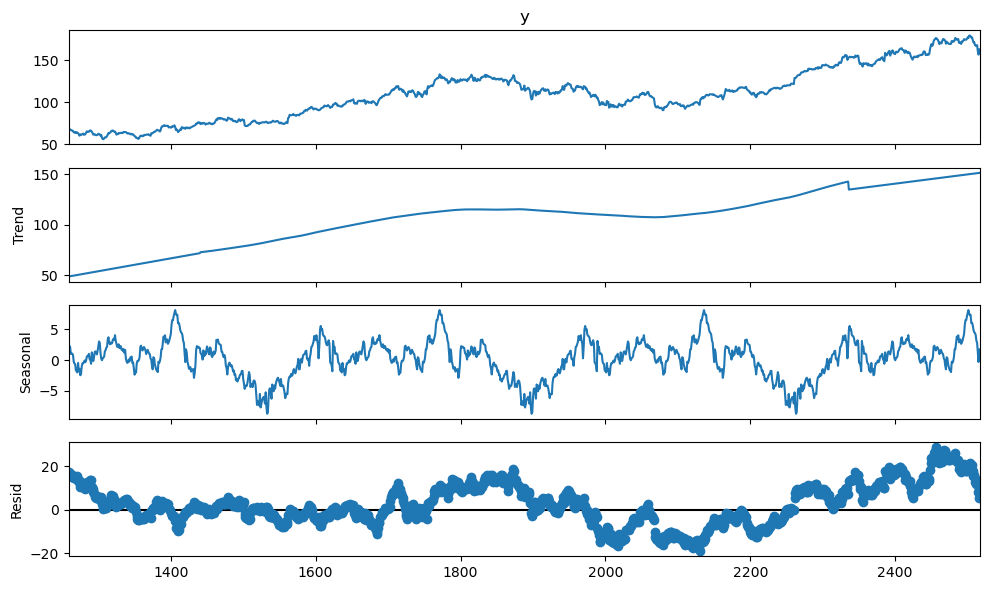

In [22]:
tr, se, re = decomposition(aplph_df, 365)

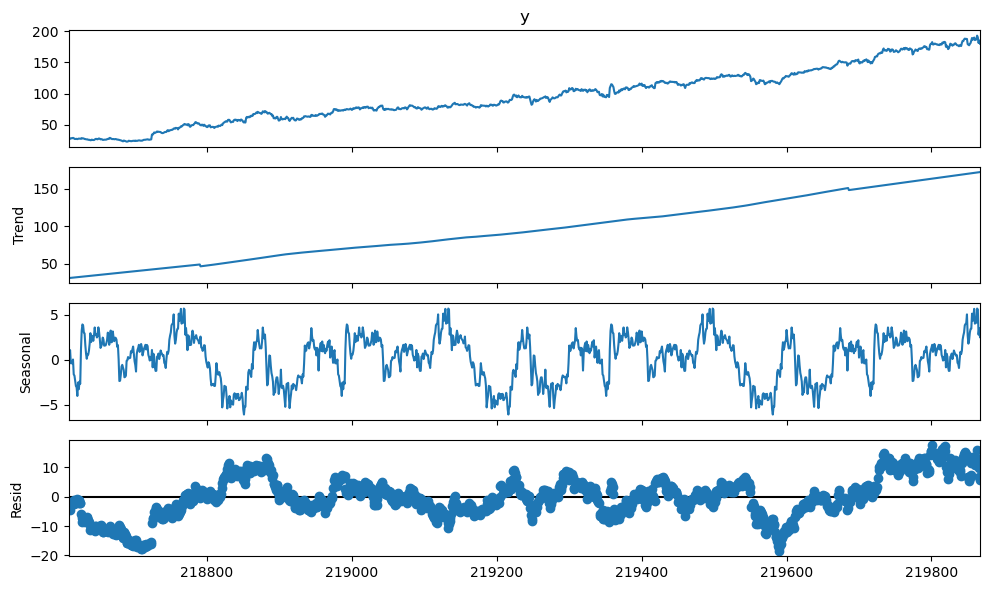

In [23]:
ftr, fse, fre = decomposition(fbph_df, 365)

### Plot the autocorrelation and partial auto-correlation plots

In [24]:
# function to retunr acf and pacf plots
def acf_pacf(df, lags):
    var = df['y']
    # plot the acf plot
    fig = plot_acf(var, lags=lags)
    fig.set_size_inches((9, 5))
    fig.tight_layout()
    plt.show()
    
    # plot the pacf plots
    fig = plot_pacf(var, lags=lags)
    fig.set_size_inches((9,5))
    fig.tight_layout()
    plt.show()

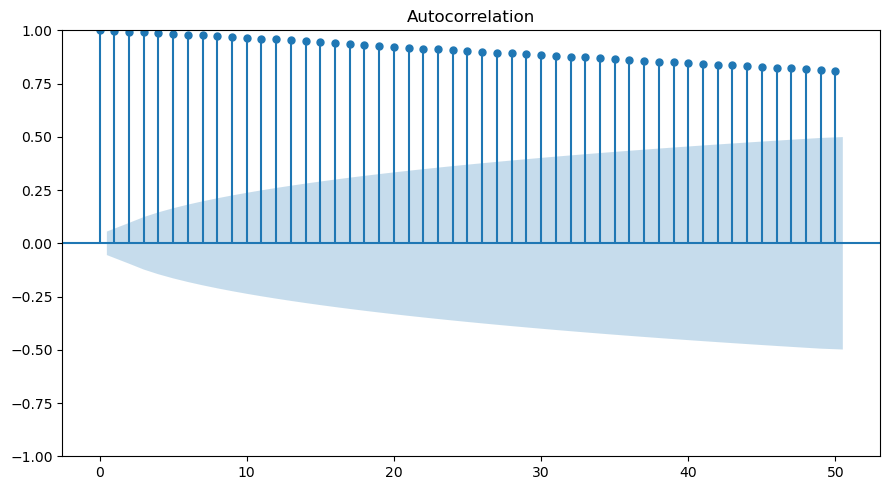

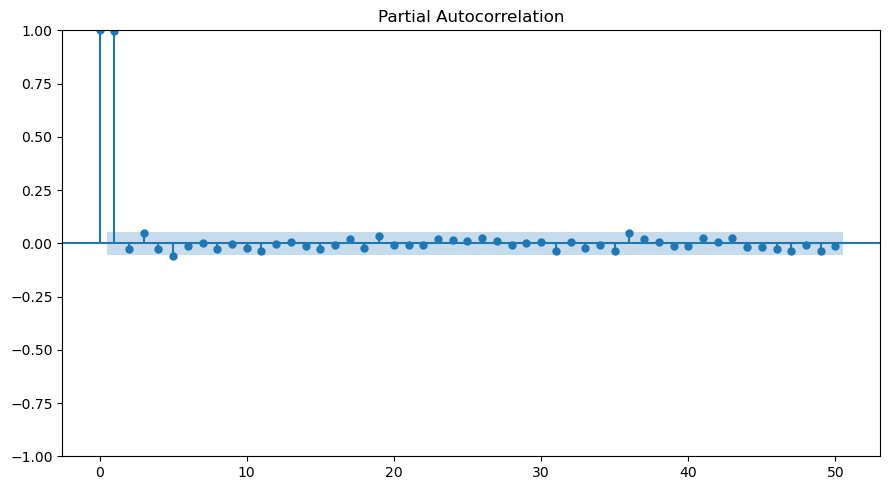

In [25]:
acf_pacf(aplph_df, 50)

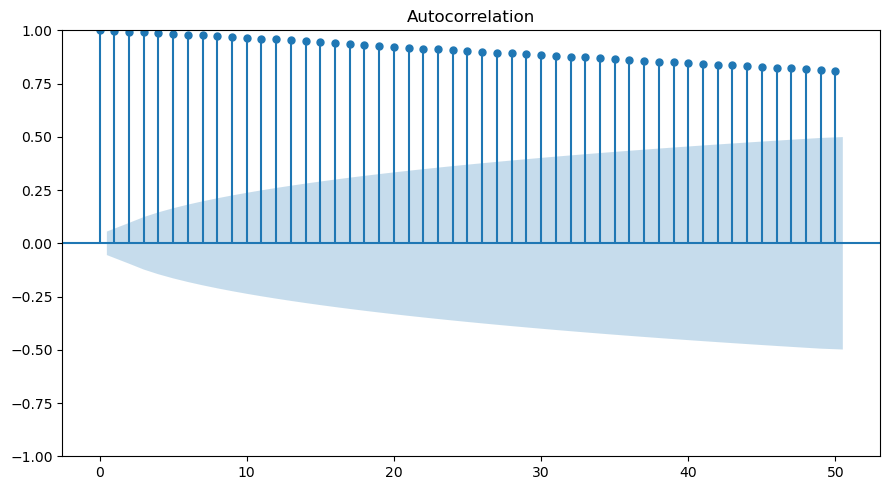

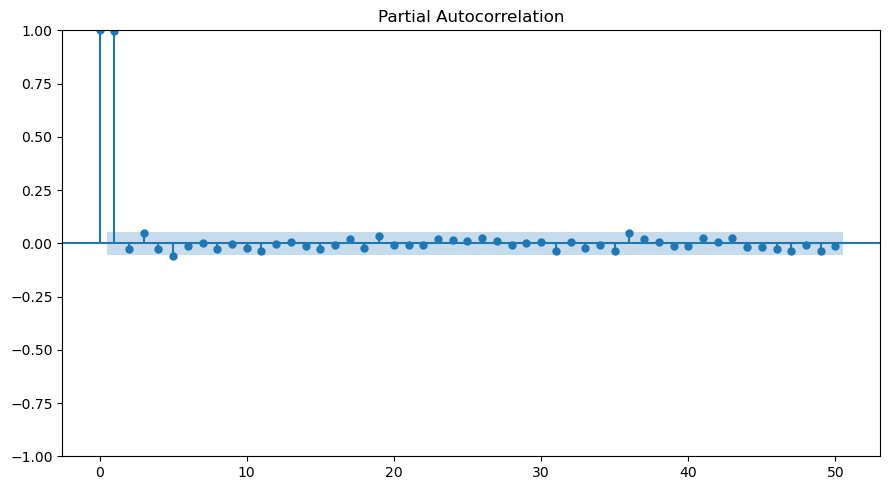

In [26]:
acf_pacf(aplph_df, 50)

## Dicky-Fuller Test(Stationarity test)
- Hypothesis to prove dicky-fuller tests

H0 - Beta = 1 (the time-series is non-stationary)

HA - Beta < 1 (the time-series is stationary)

In [27]:
# funtion to return adfuller test results
def adfuller_test(df):
    adfuller_result = adfuller(df['y'], autolag='AIC')
    adfuller_output = pd.Series(adfuller_result[:4], index=['Test statistic', 'p-value',
                                                           'Lags Used','Number of Observations Used'])
    print(adfuller_output)

In [28]:
print("adfuller test results for AAPLE")
adfuller_test(aplph_df)
print("----"*10)
print("adfuller test results for FB")
adfuller_test(fbph_df)

adfuller test results for AAPLE
Test statistic                   -0.665091
p-value                           0.855586
Lags Used                         0.000000
Number of Observations Used    1258.000000
dtype: float64
----------------------------------------
adfuller test results for FB
Test statistic                    0.177529
p-value                           0.970973
Lags Used                         8.000000
Number of Observations Used    1250.000000
dtype: float64


- Both the stocks time-series is not stationary as p-values are much greater than 0.05, hence we cannot reject the null-hypothesis.

### Finding degree of differencing

In [29]:
# find degree of differencing 
def degree_of_differencing(df, co_name):
    company_ndiffs = ndiffs(df['y'], test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {co_name}')
    
    return company_ndiffs

aapl_ddf = degree_of_differencing(aplph_df, 'APPLE')
fb_ddf = degree_of_differencing(fbph_df, 'Facebook')

The degree of differencing is 1 for APPLE
The degree of differencing is 1 for Facebook


## Train forecasting models using Auto-ARIMA
- ARIMA stands for Auto Regessive Integrated Moving Average. The model's goal is to predict future securities or financial market moves by examining the differences between values in the series instead of through the actual values. An ARIMA model can be understood by outlining each of its components as follows:

- Auto Regression (AR): Refers to a model that shows a changing variable that regresses on its own lagged or prior values.

- Integrated (I): Represents the differencing of raw observations to allow for the time series to become stationary (i.e., data values are replaced by the difference between the data values and the previous values).

- Moving Average (MA): Incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In [30]:
# funcrtion to split train and test time-series for modelling purpose
def arima_split(df, co_name):
    size = int(len(df)*0.95)
    train_df = (df['y'])[:size]
    test_df = (df['y'])[size:]
    
    print(f"data splits of company {co_name}")
    print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")
    print("-------------------------------")
    
    return train_df, test_df

apl_train, apl_test = arima_split(aplph_df, 'APPLE')
fb_train, fb_test = arima_split(fbph_df, 'FB')

data splits of company APPLE
Train Size: 1196, Test Size: 63
-------------------------------
data splits of company FB
Train Size: 1196, Test Size: 63
-------------------------------


In [31]:
def find_best_fit_arima(df, co_name):
    print(f"Arima model for {co_name}")
    model = pm.auto_arima(df, test = 'adf', 
                          start_p = 1, start_q = 1,     
                          max_p = 3, max_q = 3,
                          d = None, seasonal = True,   
                          start_P = 0, m = 3,
                          trace = True, error_action = 'ignore',  
                          suppress_warnings = True, stepwise = True,
                          D = 1, information_criterion = 'aic')

    print(model.summary())
    print('\n')
    return model



In [32]:
model_apl = find_best_fit_arima(apl_train, 'APPLE')


Arima model for APPLE
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=5737.373, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=4795.557, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=5191.240, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=5746.692, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=5067.196, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=4657.095, Time=0.38 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,0,0)(2,1,0)[3] intercept   : AIC=5740.397, Time=0.17 sec
 ARIMA(2,0,0)(2,1,0)[3] intercept   : AIC=4647.664, Time=0.45 sec
 ARIMA(2,0,0)(1,1,0)[3] intercept   : AIC=4777.434, Time=0.17 sec
 ARIMA(2,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(2,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,0,1)(2,1,0)[3] intercept   

In [33]:
model_fb = find_best_fit_arima(fb_train, 'FB')

Arima model for FB
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=5732.041, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=4820.037, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=5125.524, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=5754.032, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=5103.879, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=4678.066, Time=0.32 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(2,1,0)[3] intercept   : AIC=5709.040, Time=0.22 sec
 ARIMA(2,0,0)(2,1,0)[3] intercept   : AIC=4658.166, Time=0.46 sec
 ARIMA(2,0,0)(1,1,0)[3] intercept   : AIC=4792.198, Time=0.21 sec
 ARIMA(2,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(2,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(2,0,1)(2,1,0)[3] intercept   : A

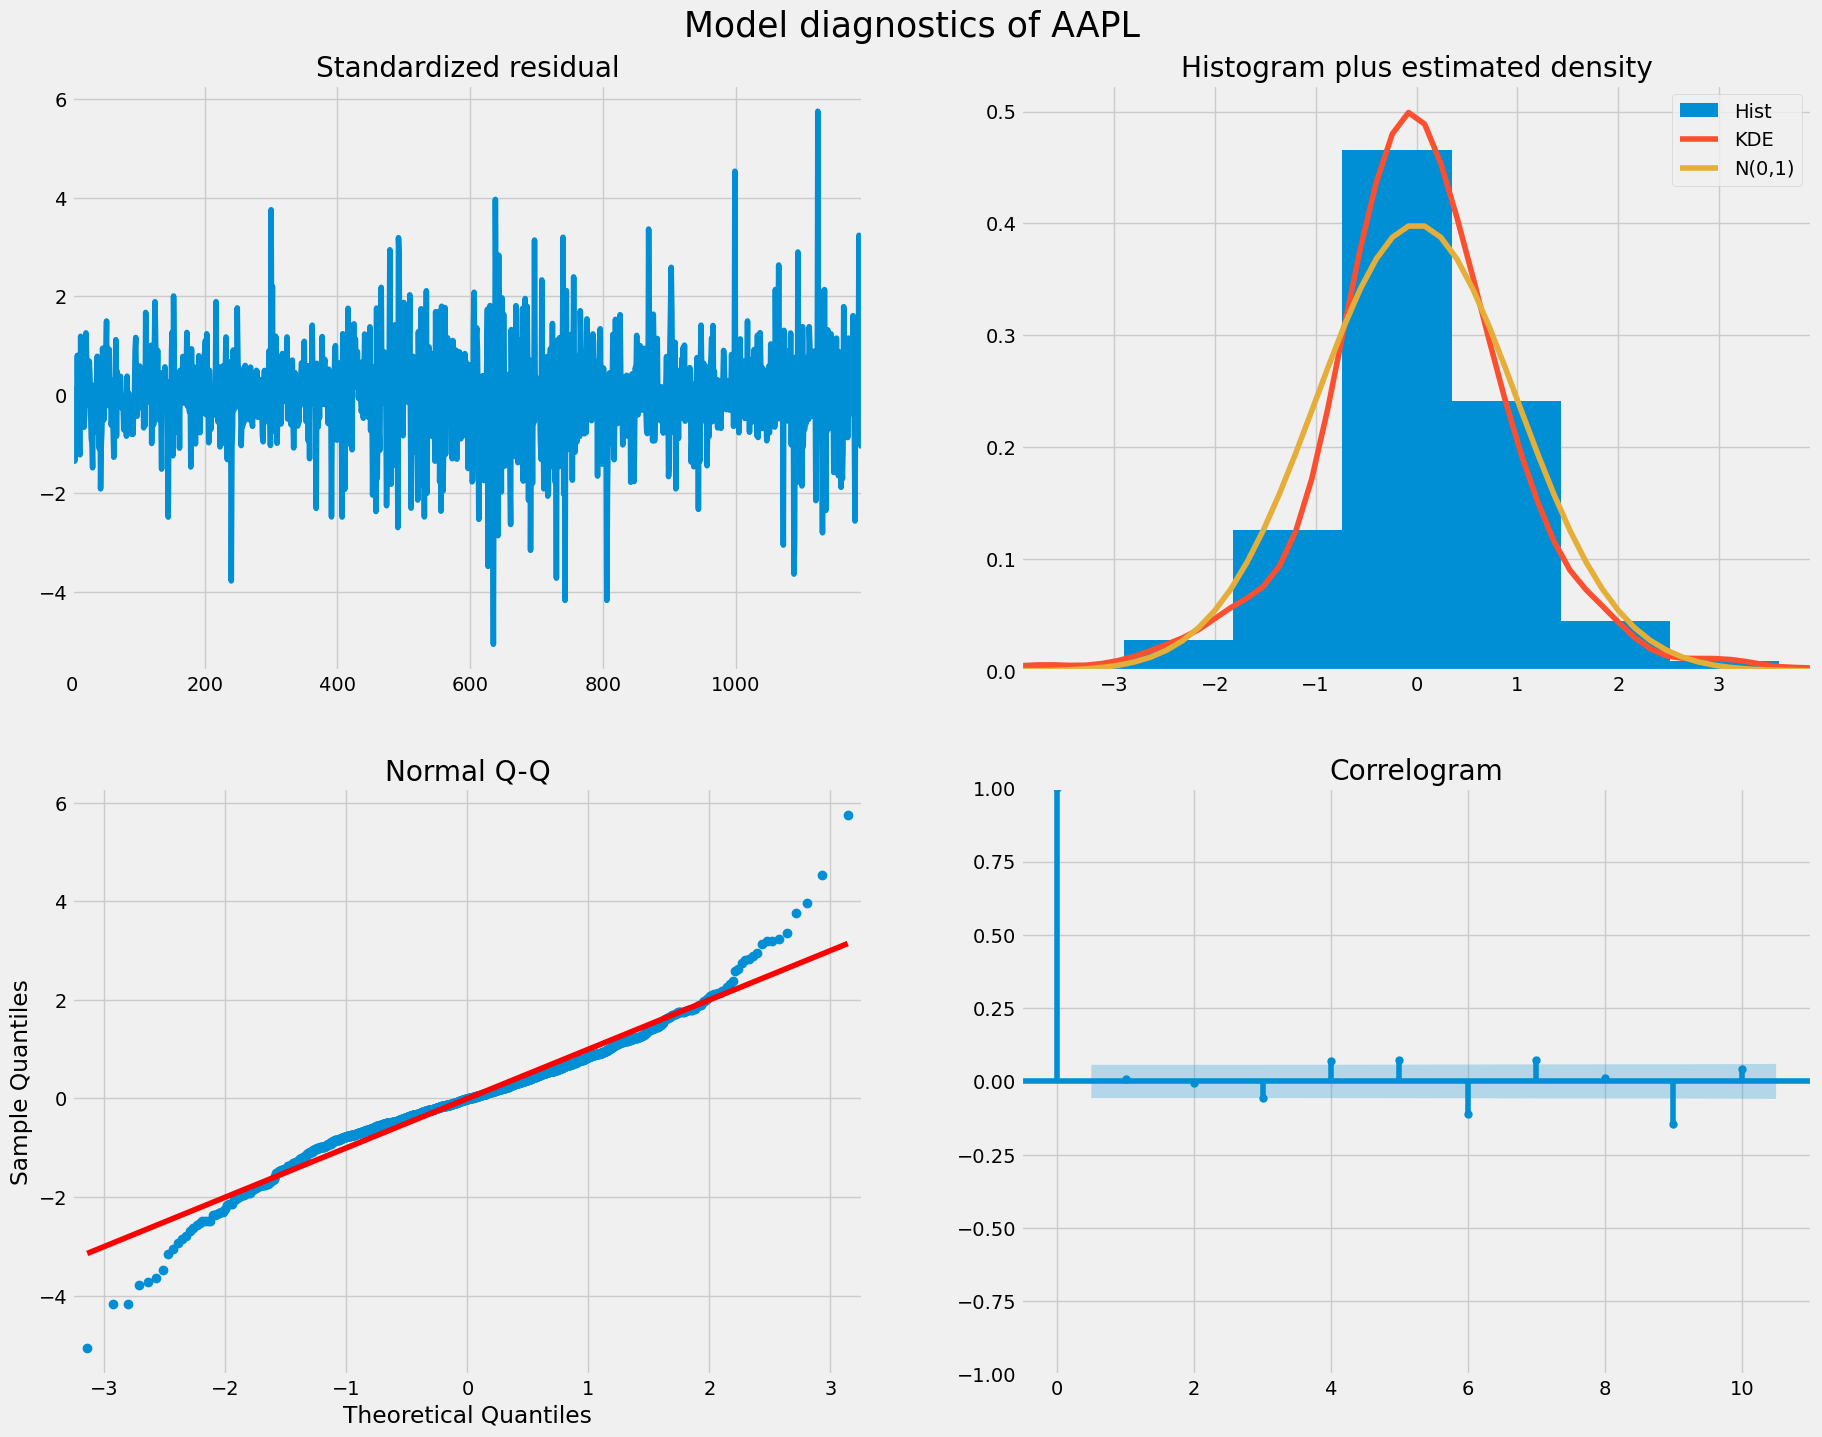

In [36]:
# let's plot forecasting models plots
def display_model_plots(model, co_name):
    plt.style.use('fivethirtyeight')
    model.plot_diagnostics(figsize = (20, 15));
    plt.suptitle(f'Model diagnostics of {co_name}', fontsize = 25)
    plt.subplots_adjust(top = 0.93)
    plt.show()
    plt.style.use('default')
    
display_model_plots(model_apl, 'AAPL')



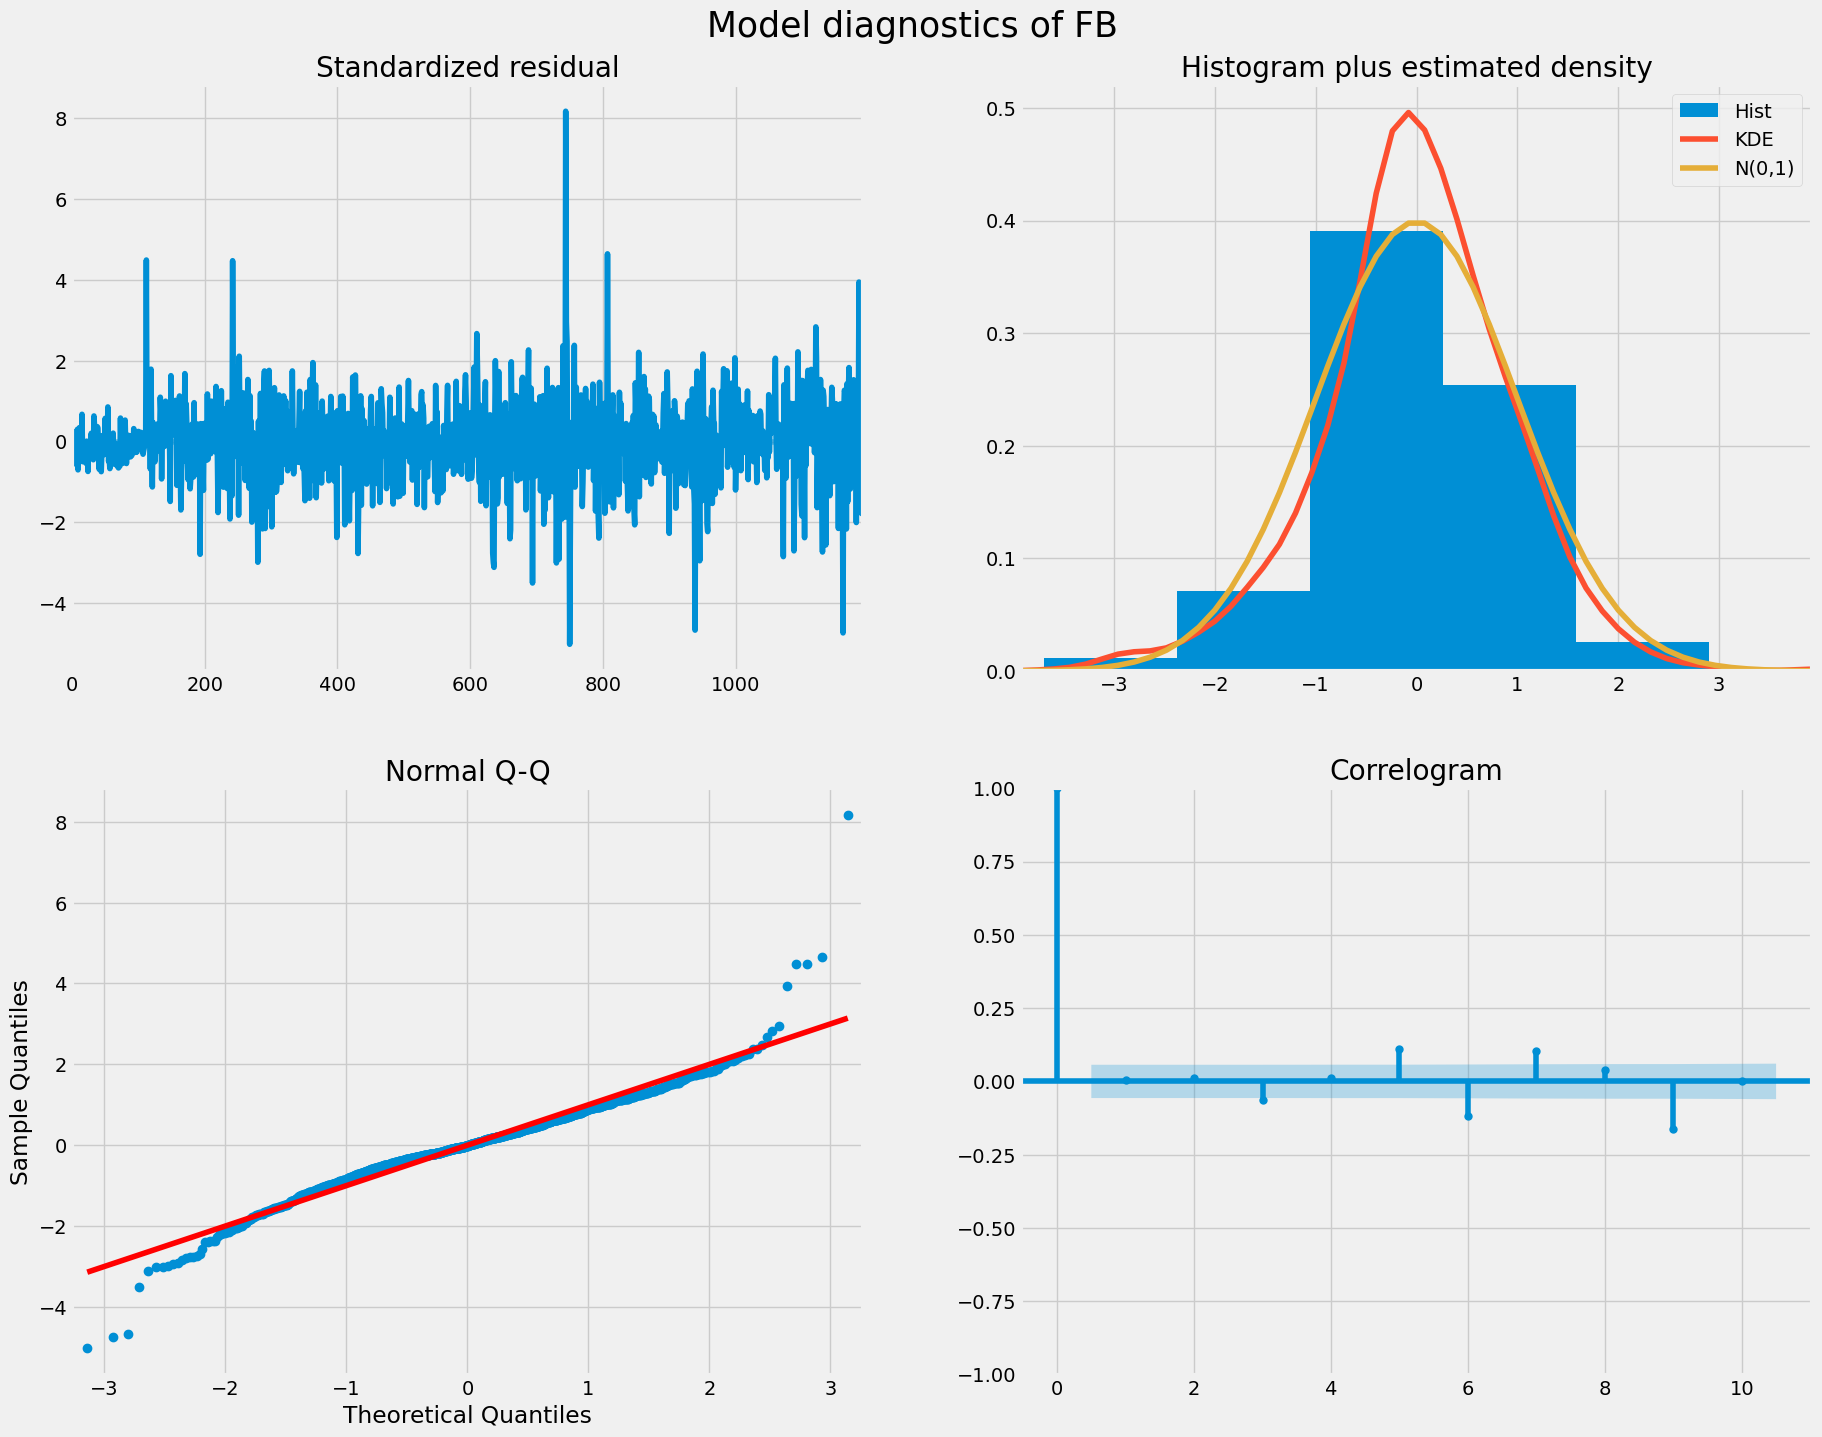

In [37]:
display_model_plots(model_fb, 'FB')

In [35]:
def make_predictions_and_print_rmse(model, test_df, co_name):
    print(f"forecasting and RMSE of {co_name}")
    
    forecast, confidence_interval = model.predict(X=test_df, n_periods = len(test_df), return_conf_int = True)
    forecasts = pd.Series(forecast, index = test_df[:len(test_df)].index)
    lower = pd.Series(confidence_interval[:, 0], index = test_df[:len(test_df)].index)
    upper = pd.Series(confidence_interval[:, 1], index = test_df[:len(test_df)].index)
    
    rmse = np.sqrt(np.mean((forecast.values - test_df.values) ** 2))
    
    print("RMSE is: ", rmse)
    
    return forecasts, lower, upper

forecast, lower, upper = make_predictions_and_print_rmse(model_apl, apl_test, 'APPLE')
print("----------------------------")
forecastf, lowerf, upperf = make_predictions_and_print_rmse(model_fb, fb_test, 'FB')

forecasting and RMSE of APPLE
RMSE is:  7.3028993591922164
----------------------------
forecasting and RMSE of FB
RMSE is:  4.2059060647719635
